In [1]:
from IPython.display import Image

# Fundamentos en Infomática Urbana: análisis y procesamiento de datos 2017 - Fing - UDELAR
### Docentes:
Sebastián Baña, 
Sergio Nesmachnow,
Renzo Massobrio



## Propuesta de trabajo final: 

### Procesamiento de datos de consumo eléctrico en computadores multicores

Jonathan Muraña - 42545567

>Propuesta: presentar un Notebook que incluya y describa scripts python utilizando las bibliotecas pandas y numpy, para el procesamiento y análisis de los datos de logs generados en los experimentos de caracterización del consumo eléctrico en  multicores 



## Motivación
Pretendo alinear los conocimientos adquiridos en el curso para potenciar el procesamiento y análisis de datos necesarios para la realización de mi tesis de maestría en informatica. Además incluir el producto final de esta tarea como material adjunto en la publicación de un artículo relacionado en el que me encuentro trabajando. 

## Descripción
Una de las actividades de la tesis consta de recolectar información de consumo eléctrico de una computadora (host) mientras se realiza la ejecución de una tarea (benchmark) que tiene un determinado perfil de utilización de recursos. De esta forma se busca relacionar el consumo eléctrico con el tipo de recurso que el benchmark está utilizando y la carga de trabajo. Para eso se utiliza la siguiente infraestructura: 

![alt text](milab_files/images/setup.png "Monitoring setup")


Los benchmarks son ejecutados en la máquina host mientras un script de polling consulta el medidor de potencia y loguea la información de consumo. Hay 4 tipos de benchmak cada uno orientado a un recurso computacional en particular (CPU, memoria, disco y red). Los benchmarks se ejecutan de forma individual y combinada, y además con distintas cargas. Un experimento consiste en uno o varios tipos de benchmarks, ejecutando, en un cierto nivel de carga. Por ejemplo el experimento "c1l37y5" coresponde al benchmark consumidor de CPU ejecutando con una carga de 35.5% y el experimento "c1f1l2525" corresponde al benckmark consumidor de CPU ejecutando combinado con el bechmark consumidor de disco (file), ambos con un nivel de carga de 25%.

Cada experimento se ejecuta 20 veces para la validez estadística.


## Fuente de datos a procesar

Existen dos fuentes de datos a procesar. Por un lado los logs de consumo (escritos en logging machine) y por otro los logs de inicio y fin de las ejecuciones de benchmarks (escritos en host). Comparando la fecha hora de ambas fuentes posible entonces saber cuánta energía consumió la ejecucción de un proceso.

### Log de consumo eléctrico / Cleaning data / Data conversion
Esta información se registra haciendo polling cada X segundos sobre el medidor PDU y registrando el consumo instantáneo un archivo de texto. Aquí se levantan desde arhivos y concatenan en un dataframe todos los logs
En particular nos interesa la fecha hora y la potencia instantánea

In [7]:
#COLLECTING

import pandas as pd
from os import walk
%pylab inline

#obtengo una lista de los nombre de archivos
EXE_DIR = "milab_files/energy/"
list_of_file_names= next(walk(EXE_DIR))[2]
#print (list_of_file_names)
#dfEnergyLog = pd.read_csv(EXE_DIR + list_of_file_names[0], sep='|')
dfEnergyLog = pd.DataFrame()
for file_name in list_of_file_names[:]:
    dfEnergyLogAux=pd.read_csv(EXE_DIR + file_name, sep='|')
    dfEnergyLog = dfEnergyLog.append(dfEnergyLogAux)

#CLEANING

import re
r = re.compile('([0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2})')
#print (dfEnergyLog[['datetime','P(W)']].tail())
#cleanDfEnergyLog = dfEnergyLog[['datetime','P(W)']][dfEnergyLog.datetime.str.match(r)]
#print (dfEnergyLog[['datetime','P(W)']][dfEnergyLog.datetime.str.match(r).str.len()>0])
cleanDfEnergyLog = dfEnergyLog[['datetime','P(W)']][dfEnergyLog.datetime.str.match(r).str.len()>0]
#cleanDfEnergyLog = new dfEnergyLog[['datetime','P(W)']]
#cleanDfEnergyLog = dfEnergyLog[['datetime','P(W)']]


#delenting row without date format
cleanDfEnergyLog['datetime'] =  pd.to_datetime(cleanDfEnergyLog['datetime'][:]
                                            , format='%Y-%m-%d %H:%M:%S')
#type(cleanDfEnergyLog['datetime'][0])
cleanDfEnergyLog['P(W)'] = pd.to_numeric(cleanDfEnergyLog['P(W)'])

print (dfEnergyLog[['datetime','P(W)']].head())
#print (dfEnergyLog[['datetime','P(W)']].tail())
#print type(dfEnergyLog['P(W)'][0])


Populating the interactive namespace from numpy and matplotlib


/home/jon/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,7,8,9,11,12,15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


              datetime P(W)
0  2017-02-27 23:59:59   57
1  2017-02-28 00:00:01   57
2  2017-02-28 00:00:02   57
3  2017-02-28 00:00:03   57
4  2017-02-28 00:00:04   57


## Log inicio y fin de ejecuciones / proccesing / conversion / Grouping by and FIlter
Al iniciar y finalizar una ejecucion se crea un archivo de texto indicando en el nombre: id del experimento, id de la ejecución, si es inicio o fin y fecha hora. El siguiente código levanta la información en un DF


### Offset entre logs
Algo a tener en cuenta es que hay que sincronizar las horas de los logs sumando la diferencia de segundos entre las horas registradas (esto es porque las horas del host y logging machine no estan sincronizadas). Tal vez es posible sincronizar de forma automática?? 

TIME_OFFSET = 10810

#medir time (logging machine)
#lun feb 27 16:04:55 UYT 2017
#node71 time (host)
#Mon Feb 27 19:05:12 UYT 2017


In [20]:
#COLLECTING

from os import walk

#obtengo una lista de los nombre de archivos
EXE_DIR = "milab_files/executions"
list_of_file_names= next(walk(EXE_DIR))[2]

#obtengo una lista de los nombre de archivos
dfExecutionsLog = pd.DataFrame(list_of_file_names)

#print (dfExecutionsLog.head())

#PROCESING

dfExecutionsLog.columns = ['data']
dfExecutionsLog = pd.DataFrame(dfExecutionsLog.data.str.split('_').tolist(), columns = ['cod','exp','data'])
dfExecutionsLogAux = pd.DataFrame(dfExecutionsLog.data.str.split('.').tolist(), columns = ['datetime','inifin'])

#no millis
dfExecutionsLog['datetime'] = dfExecutionsLogAux['datetime'].str.slice(0,-4)
dfExecutionsLog['inifin'] = dfExecutionsLogAux['inifin'] 

#print dfExecutionsLog.head()[['cod','exp','datetime','inifin']]

#CONVERSION

dfExecutionsLog['datetime'] =  pd.to_datetime(dfExecutionsLog['datetime'][:]
                                             , format='%Y|%m|%d-%H:%M:%S')
#print (dfExecutionsLog.head())

#GROUPING

dfExecutionsLogMerged = pd.merge(dfExecutionsLog, dfExecutionsLog, on='exp')[['cod_x','exp','datetime_x','inifin_x','cod_y','datetime_y','inifin_y']]
dfExecutionsLogMergedAndFiltered = dfExecutionsLogMerged[dfExecutionsLogMerged.inifin_x=='ini'][dfExecutionsLogMerged.inifin_y=='end']
print (dfExecutionsLogMergedAndFiltered.head())



      cod_x                exp          datetime_x inifin_x    cod_y  \
1    c1l100  20170228005728816 2017-02-28 00:57:28      ini   c1l100   
5     c1l25  20170227210017249 2017-02-27 21:00:17      ini    c1l25   
10  c1l62y5  20170227224717136 2017-02-27 22:47:17      ini  c1l62y5   
14  c1l37y5  20170227215039514 2017-02-27 21:50:39      ini  c1l37y5   
17    c1l75  20170227233357099 2017-02-27 23:33:57      ini    c1l75   

            datetime_y inifin_y  
1  2017-02-28 00:58:31      end  
5  2017-02-27 21:01:17      end  
10 2017-02-27 22:48:18      end  
14 2017-02-27 21:51:40      end  
17 2017-02-27 23:34:58      end  


/home/jon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Calculating utilization level

In [21]:
    
def cod2UL(cod):
  #print (cod)
  #print (type(cod))
 # print (type('12y5'))
  if '12y5' in cod:
        #print ("si")
        return 12.5
  if "25" in cod:
        return 25
  if "37y5" in cod:
        return 37.5
  if "50" in cod:
        return 50
  if "62y5" in cod:
        return 62.5
  if "75" in cod:
        return 75
  if "87y5" in cod:
        return 87.5
  if "100" in cod:
        return 100
    
        
dfExecutionsLogMergedAndFiltered['UL'] =  dfExecutionsLogMergedAndFiltered.apply(lambda x:cod2UL(x.cod_x),axis = 1) 
print (dfExecutionsLogMergedAndFiltered.head())


      cod_x                exp          datetime_x inifin_x    cod_y  \
1    c1l100  20170228005728816 2017-02-28 00:57:28      ini   c1l100   
5     c1l25  20170227210017249 2017-02-27 21:00:17      ini    c1l25   
10  c1l62y5  20170227224717136 2017-02-27 22:47:17      ini  c1l62y5   
14  c1l37y5  20170227215039514 2017-02-27 21:50:39      ini  c1l37y5   
17    c1l75  20170227233357099 2017-02-27 23:33:57      ini    c1l75   

            datetime_y inifin_y     UL  
1  2017-02-28 00:58:31      end  100.0  
5  2017-02-27 21:01:17      end   25.0  
10 2017-02-27 22:48:18      end   62.5  
14 2017-02-27 21:51:40      end   37.5  
17 2017-02-27 23:34:58      end   75.0  


## Sumarizing the offset

In [22]:


#print (cleanDfEnergyLog.head())

cleanDfEnergyLog['datetimePlusOffset']  = cleanDfEnergyLog.apply(lambda x: pd.to_datetime(x.datetime)+pd.Timedelta(seconds=10810) ,axis = 1)

print (cleanDfEnergyLog.head())
#print (cleanDfEnergyLog.tail())
#print (dfExecutionsLogMergedAndFiltered.head())
#print (dfExecutionsLogMergedAndFiltered.tail())


             datetime  P(W)  datetimePlusOffset
0 2017-02-27 23:59:59    57 2017-02-28 03:00:09
1 2017-02-28 00:00:01    57 2017-02-28 03:00:11
2 2017-02-28 00:00:02    57 2017-02-28 03:00:12
3 2017-02-28 00:00:03    57 2017-02-28 03:00:13
4 2017-02-28 00:00:04    57 2017-02-28 03:00:14


# SUMA

In [23]:


power_average = []
power_desv = []
for index, row in dfExecutionsLogMergedAndFiltered.iterrows():
  cleanDfEnergyLogCropSup = cleanDfEnergyLog[row.datetime_y > cleanDfEnergyLog.datetimePlusOffset]
  cleanDfEnergyLogCropInfAndSup = cleanDfEnergyLogCropSup[row.datetime_x < cleanDfEnergyLogCropSup.datetimePlusOffset]
  #cleanDfEnergyLogCropInfAndSup = cleanDfEnergyLog[row.datetime_x == cleanDfEnergyLog.datetimePlusOffset]
  #print (cleanDfEnergyLog.size)
  #print (cleanDfEnergyLogCropSup.size)
  #print (cleanDfEnergyLogCropInfAndSup.size)
  #print (row.datetime_y)
  #print (row.datetime_x)
  
  #print (cleanDfEnergyLogCropInfAndSup.head())
  #print ("END TAIL")
  
  aux_mean = cleanDfEnergyLogCropInfAndSup['P(W)'].mean()      
  aux_std = cleanDfEnergyLogCropInfAndSup['P(W)'].std() 
    
  if aux_mean == 0:
        print ("there is a zero")
    
    
  #print (aux_mean)

  power_average.append(aux_mean)
  power_desv.append(aux_std)
    
dfExecutionsLogMergedAndFiltered['power_average'] = pd.Series(power_average).values
#dfExecutionsLogMergedAndFiltered['power_desv'] = pd.Series(power_desv).values

#print (dfExecutionsLogMergedAndFiltered[['cod_x','datetime_x','power_average','power_desv']])   
print (dfExecutionsLogMergedAndFiltered.groupby(['UL']).mean())
print (dfExecutionsLogMergedAndFiltered.groupby('UL').std())
       


       power_average
UL                  
12.5      121.587226
25.0      136.552418
37.5      142.531893
50.0      152.800439
62.5      163.190844
75.0      175.769725
87.5      185.826720
100.0     194.640200
       power_average
UL                  
12.5        1.662569
25.0        2.017633
37.5        2.115192
50.0        2.903931
62.5        2.745200
75.0        1.791475
87.5        2.250113
100.0       4.304858


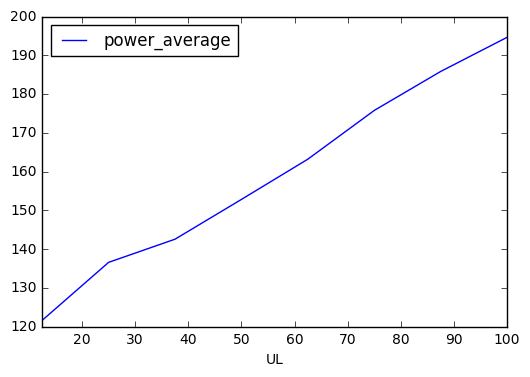

In [25]:
dfExecutionsLogMergedAndFiltered.groupby(['UL']).mean().plot()

## Otros

El notebook se documentará en idioma inglés

## Además

* Hay experimentos complemetarios de performance de los benchmarks que buscan relacionar el tiempo de finalización  (makespan) de los procesos con respecto a la carga. De esta forma es posible realizar análisis de eficiencia enerǵetica
* Los experimetos se realizaron para dos host, por lo tanto hay duplicación de todos los logs, y esto permite realizar un análisis comparativo

## Conclusiones

La propuesta me parece interesante ya que va a permitir manejar con calidad y transparencia el procesamiento de los datos de los experimetos de la tesis y además abre la oportunidad de realizar nuevos análisis sobre la información que enriquezcan la investigación, como pueden ser:

* validadiones estadísticas utiliando bibliotecas científicas de python
* graficar distintas presentaciones de los datos con facilidad
* machine learning para detectar correlaciones entre las variables
* interpolaciones utilizando bibliotecas existentes
* agregar nueva información empírica facilmente
* y más ...


# LOG DE ENERGIA